# TELCO CHURN ANALYSIS

# Business Understanding
In the fiercely competitive telecommunications industry, customers have the liberty to choose from a multitude of network providers, making customer retention a critical concern. Churn, the phenomenon of customers switching from one operator to another, poses significant challenges for telecom companies.

The annual churn rate in this industry typically ranges between 15% to 25%, highlighting the need to prioritize customer retention. To thrive in this competitive market, telecom companies recognize the strategic importance of retaining high-value customers. Therefore, the reduction of churn rate is a top business priority for these companies.

To effectively combat customer churn, telecom companies need accurate predictive models that can identify customers at high risk of churn. By analyzing customer-level data, such models can be developed and used to identify key indicators of churn.

The process of churn usually undergoes three phases:
The satisfaction phase: During this phase, customers generally exhibit contentment with the provided services and behave in line with their usual patterns.

The trigger phase: In this phase, customer experiences and satisfaction levels start to fluctuate. Triggers for churn can include enticing offers from competitors, unjust charges, deteriorating service quality, and other factors. Customer behavior during this phase often deviates from their satisfaction months. Identifying customers at a high risk of churn during this period is critical, as timely interventions can be implemented, such as matching competitors' offers or improving service quality. The prediction of the likelihood of churn using the best model is done in this phase.

The churn phase: This phase represents the point at which a customer officially seizes to patronize the company. Such customer is said to have churn. Most times, the churn customer would switch to a competitor company and might remain with them.

By comprehending the customer lifecycle and effectively identifying customers at risk of churn during the trigger phase, telecom companies can proactively implement targeted retention strategies. These strategies include efforts to match competitors' offerings, enhance service quality, and create personalized experiences. Such proactive measures hold the potential to bolster customer satisfaction, reduce churn rates, and cement long-lasting relationships with valuable customers.

# Project Scenario
For this project, I am the Data Scientist of a prominent telecom firm called Vodafone Corporation. I will analyze the available customer-level data of the company and build eight (8) different machine learning models with the data. These models will be tuned for optimal performance and the best model can be used to predict the likelihood of churn. I will identify the key indicators of churn, and recommend solutions to help the company achieve a decline in churn rate, high customer satisfaction and increase in customer retention/longevity.

# Hypothesis

Null Hypothesis: There is no relationship between the monthly charges and the churn of customers.

Alternate Hypothesis: There is a relationship between the monthly charges and the churn of customers.

# Analytical Questions
1. What is the overall churn rate of the telecommunication company?
2. What is the average monthly charges to churn customers compared to non-churn customers?
3. What percentage of the top 100 most charged customers churned?
4. What percentage of the top 100 least charged customers churned?
5. What is the churn rate of male customers with partners, dependents and high monthly charges?
6. What is the churn rate of customers without online security?
7. What is the churn rate of customers without online backup?
8. What is the churn rate of customers without device protection?
9. What is the churn rate of customers without Tech support?
10. How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?
11. How does the length of customers' contract affect their likelihood of churn?
12. How does the length of customers' tenure affect their likelihood of churn?

In [207]:
# Importing the needed packages
import pandas as pd
import numpy as np

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for testing the hypothesis
import scipy.stats as stats

# Library for pandas profiling
from pandas_profiling import ProfileReport

# Library for splitting the train data
from sklearn.model_selection import train_test_split

# Library for feature scaling
from sklearn.preprocessing import StandardScaler

# Library for feature encoding
from sklearn.preprocessing import OneHotEncoder

# Libraries for balancing the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Libraries for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Libraries for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Library for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Library for working with operating system
import os

# Library to serialize a Python object into a flat byte stream and transform a byte stream back into a Python object
import pickle

# Library to handle warnings
import warnings
warnings.filterwarnings('ignore')

There are three datasets for this analysis which are located in three different places. The first dataset can be found on a SQL server and is to be accessed remotely. The second dataset can be found as an excel file on One Drive. The access link was provided and used to access and download the dataset. While the third dataset can be found as a csv file on a Github repository whose link was provided as well and used to clone the dataset into the local machine.

The first and last datasets have been identified as the train datasets, while the second dataset has been identifed as the test dataset. The train datasets will be assessed and merged together, and used to build models independently. While the test dataset will be used to test the models independently.

## Accessing the first dataset

The first dataset was collected from a SQL database by first passing a connection string using the pyodbc library. Afterwards a SQL query was used to obtain the dataset. This is as shown below.

In [208]:
# Load the environment variable in the .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# The connection string is an f string that includes all the variable above to extablish a connection to the server.
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [209]:
# Using the connect method of the pyodbc library to pass in the connection string.

# N/B: This will connect to the server and might take a few seconds to be complete.
# Check your internet connection if it takes more time than necessary.

connection = pyodbc.connect(connection_string)

In [210]:
# Get the dataset using the SQL query shown below
# dbo.LP2_Telco_churn_first_3000 is the name of the dataset, dbo being a naming convention in Microsoft SQL Server.

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)

# Save the dataset
df1.to_csv(r'data/Telco-churn-first-3043.csv')

# Show the dataset
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## Accessing the second dataset (test dataset)

The second dataset which was specified as the test dataset was downloaded from a given Onedrive link.

In [211]:
# Loading the test dataset.

test_data = pd.read_excel('data/Telco-churn-second-2000.xlsx')
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## Accessing the last dataset

The last dataset was collected from Azubi Africa's GitHub repository.

In [212]:
# Loading the last dataset.

df3 = pd.read_csv('data/LP2_Telco-churn-last-2000.csv')

In [213]:
# Displaying the first five rows of the last dataset.

df3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [214]:
# Inspecting the columns of the first dataset.

df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [215]:
# Inspecting the columns of the last dataset.

df3.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [216]:
# Since both datasets have the same column names and index number, they can be concatenated to have the train dataset.

train_data = pd.concat([df1, df3])

# Saving the train dataset to a new csv file.
train_data.to_csv('data/Train-Data.csv')

train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## EDA

In [217]:
# Checking the number of rows and columns on the train dataset.

train_data.shape

(5043, 21)

In [218]:
# Checking the number of rows and columns on the test dataset.

test_data.shape

(2000, 20)

The train dataset has 5043 columns and 21 columns while the test dataset has 2000 rows and 20 columns. Let's identify the column in the train dataset that is absent in the test dataset.

In [219]:
# Inspecting the columns of the train dataset.

train_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [220]:
# Inspecting the columns of the test dataset.

test_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

As can be seen, the test dataset has the same columns as the train dataset with the exception of the churn column which can be found on the train dataset alone. This is understandable as the churn column on the train dataset provides information on whether customers churn or  not, which is used to build the best ML model. This column is not needed on the test dataset, rather the model built is tested on the test dataset to check the ability of the model to predict whether a customet will churn or not.

In [221]:
# Checking the datatypes and the presence of missing values on the train dataset.

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [222]:
# Checking the datatypes and the presence of missing values on the test dataset.

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


Note that the datatype of the 'SeniorCitizen' column is an object on the train data but an integer on the test data.

In [223]:
# Confirming the number of cells with missing values on each column of the train dataset.

train_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

The 'MultipleLines' column has 269 missing values. The 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' columns all have 651 missing values. This needs to be evaluated further to find out if these missing values are exactly on the same rows. The 'TotalCharges' column has 5 missing values while the 'Churn' column has 1 missing value.

In [224]:
# Confirming that there are no missing values on the test dataset.

test_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

There are no missing values on the test dataset.

In [225]:
# Checking for the presence of duplicates on the train dataset.

train_data.duplicated().sum()

0

There are no duplicate rows on the train dataset.

In [226]:
# Checking for the presence of duplicates on the test dataset.

test_data.duplicated().sum()

0

There are no duplicate rows on the test dataset.

# Data Transformation

In [227]:
# Investigating the columns on the train dataset.

train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: [False True]
column: Partner - unique value: [True False 'No' 'Yes']
column: Dependents - unique value: [False True 'No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: [False True 'Yes' 'No']
column: MultipleLines - unique value: [None False True 'No' 'No phone service' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: [False True None 'No' 'Yes' 'No internet service']
column: OnlineBackup - unique value: [True False None 'No' 'Yes' 'No internet service']
column: DeviceProt

There are many coloumns with unnecessary values such as True, False, 'No phone service' and/or  'No internet service'.
These values will be replaced with 'Yes' or 'No' as appropriate to ensure consistency.

True will be replaced with 'Yes' because True means that the customers receive those services. While False, 'No phone service' and 'No internet service' will be replaced with 'No' because they mean that the customers do not (or cannot) receive those services. 

In [228]:
# Replace True with 'Yes' and replace False, 'No internet service' and 'No phone service' with 'No' in the train dataset.
train_data = train_data.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace = False)

# Confirm that the changes on the train dataset have been effected.
train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: ['No' 'Yes']
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: [None 'No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes' None]
column: OnlineBackup - unique value: ['Yes' 'No' None]
column: DeviceProtection - unique value: ['No' 'Yes' None]
column: TechSupport - unique value: ['No' 'Yes' None]
column: StreamingTV - unique value

None is the Boolean representation of missing values. The columns with None are all categorical columns. The mode of these columns will be obtained and used to replace None.

In [229]:
# Replace None on each column with the mode of the column.
def replace_none_with_mode(train_data):
   categorical_cols = train_data.select_dtypes(include='object').columns  # Select categorical columns

   for col in categorical_cols:
       mode_val = train_data[col].mode()[0]  # Calculate the mode of the column
       train_data[col] = train_data[col].replace({None: mode_val})  # Replace None values with the mode

   return train_data
train_data = replace_none_with_mode(train_data)

# Confirm that the changes on the train dataset have been effected.
train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: ['No' 'Yes']
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: ['No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['Yes' 'No']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['No' 'Yes']
column: St

In [230]:
# Investigate the columns on the test dataset.

test_data.columns
for column in test_data.columns:
    print('column: {} - unique value: {}'.format(column, test_data[column].unique()))

column: customerID - unique value: ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
column: gender - unique value: ['Male' 'Female']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['No' 'Yes']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
column: PhoneService - unique value: ['Yes' 'No']
column: MultipleLines - unique value: ['Yes' 'No' 'No phone service']
column: InternetService - unique value: ['Fiber optic' 'No' 'DSL']
column: OnlineSecurity - unique value: ['No' 'No internet service' 'Yes']
column: OnlineBackup - unique value: ['No' 'No internet service' 'Yes']
column: DeviceProtection - unique value: ['No' 'No internet service' 'Yes']
column: TechSupport - unique v

In [231]:
# Replace True with 'Yes' and replace False, 'No internet service' and 'No phone service' with 'No' in the test dataset.
test_data = test_data.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace = False)

# Confirm that the changes on the test dataset have been effected.
test_data.columns
for column in test_data.columns:
    print('column: {} - unique value: {}'.format(column, test_data[column].unique()))

column: customerID - unique value: ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
column: gender - unique value: ['Male' 'Female']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['No' 'Yes']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
column: PhoneService - unique value: ['Yes' 'No']
column: MultipleLines - unique value: ['Yes' 'No']
column: InternetService - unique value: ['Fiber optic' 'No' 'DSL']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['No' 'Yes']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['Yes' 'No']
column: Streaming

In [232]:
# Drop the customerID column from the train dataset since it has unique values that are non-beneficial to our modelling

train_data.drop(columns='customerID', inplace=True)

In [233]:
# Drop the customerID column from the test dataset since it has unique values that are non-beneficial to our modelling

test_data.drop(columns='customerID', inplace=True)

In [234]:
# Checking for missing values on the train dataset.

train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The train dataset no longer has missing values. This is because None values (which is a boolean representation of missing values) has been changed to No.

In [235]:
# Investigating the 'SeniorCitizen' column in the test dataset.

test_data['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

The 'SeniorCitizen' column has numerical vales (0 and 1). These will be changed to 'No' and 'Yes' respectively in order to change the column datatype to an object.

In [236]:
# Replace 0 with 'No' and 1 with Yes in the 'SeniorCitizen' column of the test dataset.
test_data['SeniorCitizen'] = test_data['SeniorCitizen'].replace({
    0: 'No',
    1: 'Yes'
}, inplace = False)

# Confirm that the changes on the test data has been effected
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   object 
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [237]:
# Checking for missing values on the test dataset.

test_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

The test data has no missing values.

In [238]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

Total Charges column has an object datatype. This needs to be converted to float to enable us do some calculations on the column. The column will be investigated to see some of its features.

In [239]:
# Investigating the 'TotalCharges' column in the train dataset.

train_data['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [240]:
# Converting the datatype of the 'TotalCharges' column in the train dataset to float by changing the contents to
# numerical values.

train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors = 'coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

In [241]:
# Checking for missing values

train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
Churn               0
dtype: int64

The 'TotalCharges' column now has three missing values. These will be replaced with the mean value since it's now a numerical column.

In [242]:
# Calculate the mean of the 'TotalCharges' column
mean_value = train_data['TotalCharges'].mean()

# Fill missing values with the mean value
train_data['TotalCharges'] = train_data['TotalCharges'].fillna(mean_value)

# Confirm that their are no missing values
train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [243]:
# Investigating the 'TotalCharges' column in the test dataset.

test_data['TotalCharges'].unique()

array([1059.55, 181.8, 2212.55, ..., 552.95, 7053.35, 301.55],
      dtype=object)

In [244]:
# Converting the datatype of the 'TotalCharges' column in the test dataset to float by changing the contents to
# numerical values.

test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors = 'coerce')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   object 
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [245]:
# Checking for missing values

test_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64

In [246]:
# Calculate the mean of the 'TotalCharges' column
mean_value = test_data['TotalCharges'].mean()

# Fill missing values with the mean value
test_data['TotalCharges'] = test_data['TotalCharges'].fillna(mean_value)

# Confirm that their are no missing values
test_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [247]:
# Obtain the categorical and numerical columns of the train dataset
train_cat = train_data.select_dtypes(include=['object']).columns
train_num = train_data.select_dtypes(include=['float64', 'int64']).columns

# Obtain the categorical and numerical columns of the test dataset
test_cat = test_data.select_dtypes(include=['object']).columns
test_num = test_data.select_dtypes(include=['float64', 'int64']).columns

In [248]:
# Evaluate the categorical values on the train dataset.

train_data[train_cat].describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043
unique,2,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,2559,4224,2585,3482,4554,2913,2248,3587,3311,3299,3552,3098,3061,2744,2996,1700,3707


In [249]:
# Evaluate the numerical values on the train dataset.

train_data[train_num].describe()

,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2299.799108
std,24.529807,30.068133,2268.819487
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,416.650000
50%,29.000000,70.550003,1400.849976
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


In [250]:
# Evaluate the correlation of the numerical values on the train dataset.

train_data[train_num].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.240645,0.826017
MonthlyCharges,0.240645,1.000000,0.646841
TotalCharges,0.826017,0.646841,1.000000


<Axes: >

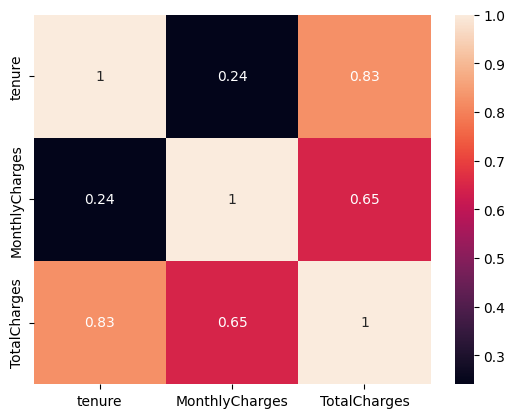

In [251]:
# Visualizing the correlation with a heatmap

sns.heatmap(train_data[train_num].corr(), annot=True)

# Save the chart as an image file
# plt.savefig('Correlation of the numerical columns of the train dataset.png')

Since there are calculations to be done on the 'Churn' column of the train dataset while answering the analytical questions, 'No' and 'Yes' values will be changed to 0 and 1 respectively in order to convert the column to a numerical column.

In [252]:
# Changing 'No' and 'Yes' to 0 and 1 respectively on the 'Churn' column of the train dataset.

train_data['Churn'] = train_data['Churn'].replace(['No', 'Yes'], [0,1])
train_data['Churn'].unique()

array([0, 1], dtype=int64)

# Hypothesis Testing

Hypothesis
Null Hypothesis: There is no relationship between the monthly charges and the churn of customers.

Alternate Hypothesis: There is a relationship between the monthly charges and the churn of customers.

The hypothesis was tested using chi-square test.

In [253]:
# Define the null hypothesis.
null_hypothesis = "There is no relationship between the monthly charge and churn of customers."

# Define the alternative hypothesis.
alternative_hypothesis = "There is a relationship between the monthly charge and churn of customers."

# Perform the chi-square test
observed = pd.crosstab(train_data['MonthlyCharges'], train_data['Churn'])

chi2, p_value, _, _ = stats.chi2_contingency(observed)


# Set the significance level
alpha = 0.05


# Print the test results
print("Null Hypothesis:", null_hypothesis)

print("Alternative Hypothesis:", alternative_hypothesis)

print("Significance Level (alpha):", alpha)

print("Chi-square statistic:", chi2)

print("P-value:", p_value)


# Compare the p-value with the significance level
if p_value < alpha:

    print("Result: Reject the null hypothesis. There is a relationship between the monthly charges and churn of customers.")

else:

    print("Result: Fail to reject the null hypothesis. There is no relationship between monthly charges and churn of customers.")

Null Hypothesis: There is no relationship between the monthly charge and churn of customers.
Alternative Hypothesis: There is a relationship between the monthly charge and churn of customers.
Significance Level (alpha): 0.05
Chi-square statistic: 2435.9382488559727
P-value: 2.9228176168391307e-08
Result: Reject the null hypothesis. There is a relationship between the monthly charges and churn of customers.


# Answering Questions with Visualizations

###  Analytical Questions
1. What is the overall churn rate of the telecommunication company?
2. What is the average monthly charges to churn customers compared to non-churn customers?
3. What percentage of the top 100 most charged customers churned?
4. What percentage of the top 100 least charged customers churned?
5. What is the churn rate of male customers with partners, dependents and high monthly charges?
6. What is the churn rate of customers without online security?
7. What is the churn rate of customers without online backup?
8. What is the churn rate of customers without device protection?
9. What is the churn rate of customers without Tech support?
10. How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?
11. How does the length of customers' contract affect their likelihood of churn?
12. How does the length of customers' tenure affect their likelihood of churn?

# Question 1
What is the overall churn rate of the telecommunication company?

Total Customers: 5043
Churned Customers: 1336
Churn Rate: 26.5%


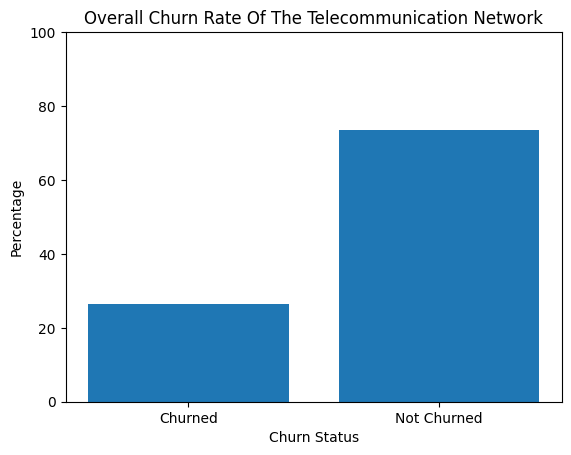

In [254]:
# Calculate the churn rate
total_customers = len(train_data)
churned_customers = train_data['Churn'].sum()
churn_rate = (churned_customers / total_customers) * 100

# Display the churn rate
print('Total Customers:', total_customers)
print('Churned Customers:', churned_customers)
print(f'Churn Rate: {churn_rate.round(1)}%')

# Plot the churn rate
plt.bar(['Churned', 'Not Churned'], [churn_rate, 100-churn_rate])
plt.title('Overall Churn Rate Of The Telecommunication Network')
plt.xlabel('Churn Status')
plt.ylabel('Percentage')
plt.ylim([0, 100])

# Save the chart as an image file
# plt.savefig('Overall Churn Rate Of The Telecommunication Network.png')

# Display the chart
plt.show()

With 5043 customers initially out of which 1336 have churned, the telecommunication network has a churn rate of 26.5%.

# Question 2
What is the average monthly charges to churn customers compared to non-churn customers?

Average Monthly Charges To Churn Customers: $75.21
Average Monthly Charges To Non-Churn Customers: $61.44


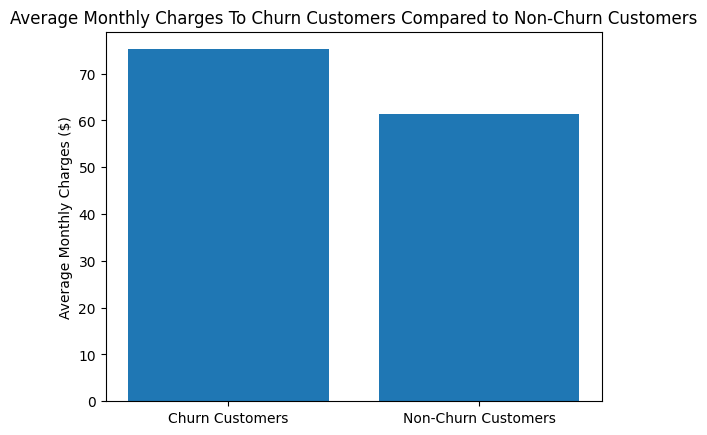

In [255]:
# Separate churn and non-churn customers
churn_customers = train_data[train_data['Churn'] == 1]
non_churn_customers = train_data[train_data['Churn'] == 0]

# Calculate the average monthly charges for churn and non-churn customers
avg_churn_charges = churn_customers['MonthlyCharges'].mean()
avg_non_churn_charges = non_churn_customers['MonthlyCharges'].mean()

# Display the average charges
print(f'Average Monthly Charges To Churn Customers: ${round(avg_churn_charges, 2)}')
print(f'Average Monthly Charges To Non-Churn Customers: ${round(avg_non_churn_charges, 2)}')

# Plot the average charges
labels = ['Churn Customers', 'Non-Churn Customers']
charges = [avg_churn_charges, avg_non_churn_charges]
plt.bar(labels, charges)
plt.ylabel('Average Monthly Charges ($)')
plt.title('Average Monthly Charges To Churn Customers Compared to Non-Churn Customers')
plt.show()

As shown, the average monthly charges to churn customers is 75.21 dollars, higher than the average monthly charges to non-churn customers (61.44 dollars).

# Question 3
What percentage of the top 100 most charged customers churned?

The Percentage Of The Top 100 Most Charged Customers Who Churned: 7.000000000000001%


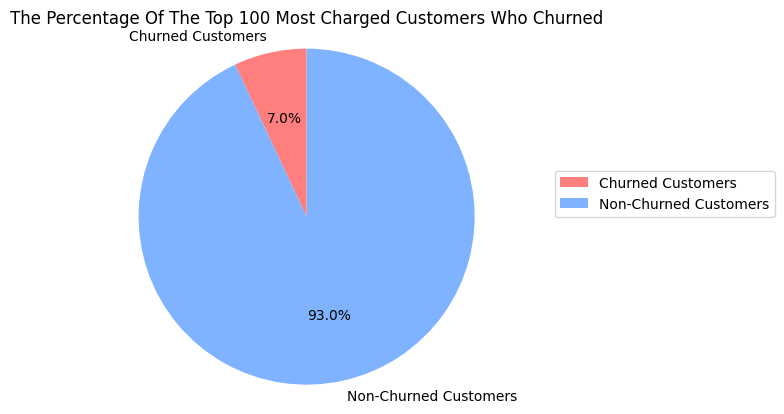

In [256]:
# Sort the DataFrame by TotalCharges in descending order

most_charged_data = train_data.sort_values(by='TotalCharges', ascending=False)

# Select the top 100 most charged customers
top_100_most_charged_customers = most_charged_data.head(100)

# Count the number of churned customers among the top 100
most_charged_churned_customers = top_100_most_charged_customers[top_100_most_charged_customers['Churn'] == 1]
most_charged_churned_count = most_charged_churned_customers.shape[0]

# Calculate the percentage of churned customers
most_charged_percentage_churned = (most_charged_churned_count / 100) * 100

# Display the result
print(f'The Percentage Of The Top 100 Most Charged Customers Who Churned: {most_charged_percentage_churned}%')

# Create a pie chart to visualize the results
labels = ['Churned Customers', 'Non-Churned Customers']
sizes = [most_charged_percentage_churned, 100 - most_charged_percentage_churned]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the top 100 most charged customers who churned
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('The Percentage Of The Top 100 Most Charged Customers Who Churned')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('The Percentage Of The Top 100 Most Charged Customers Who Churned.png')

# Display the chart
plt.show()

At an overall churn rate of 26.5%, only 7% of the top 100 most charged customers churned. This suggests that the total charges are not the only determinant of churn. There will be other factors that influenced the churn rate.

# Question 4
What percentage of the top 100 least charged customers churned?

The Percentage Of The Top 100 Least Charged Customers Who Churned: 33.0%


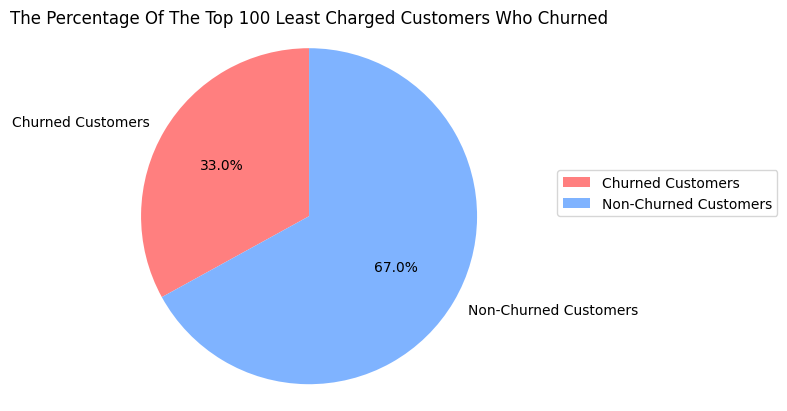

In [257]:
# Sort the DataFrame by TotalCharges in ascending order

least_charged_data = train_data.sort_values(by='TotalCharges', ascending=True)

# Select the top 100 least charged customers
top_100_least_charged_customers = least_charged_data.head(100)

# Count the number of churned customers among the top 100
least_charged_churned_customers = top_100_least_charged_customers[top_100_least_charged_customers['Churn'] == 1]
least_charged_churned_count = least_charged_churned_customers.shape[0]

# Calculate the percentage of churned customers
least_charged_percentage_churned = (least_charged_churned_count / 100) * 100

# Display the result
print(f'The Percentage Of The Top 100 Least Charged Customers Who Churned: {least_charged_percentage_churned}%')

# Create a pie chart to visualize the results
labels = ['Churned Customers', 'Non-Churned Customers']
sizes = [least_charged_percentage_churned, 100 - least_charged_percentage_churned]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the top 100 most charged customers who churned
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('The Percentage Of The Top 100 Least Charged Customers Who Churned')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('The Percentage Of The Top 100 Least Charged Customers Who Churned.png')

# Display the chart
plt.show()

33% of the top 100 least charged customers churned. This strenghtens the argument that the charges are not the only determinant of churn. A good number of those that got the least charges churned although the charges they paid were reasonably low.

# Question 5
What is the churn rate of male customers with partners, dependents and high monthly charges?

N/B: It is assumed that high monthly charges refer to monthly charges equal to or above $100.

Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: 20.0%
Non-Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: 80.0%


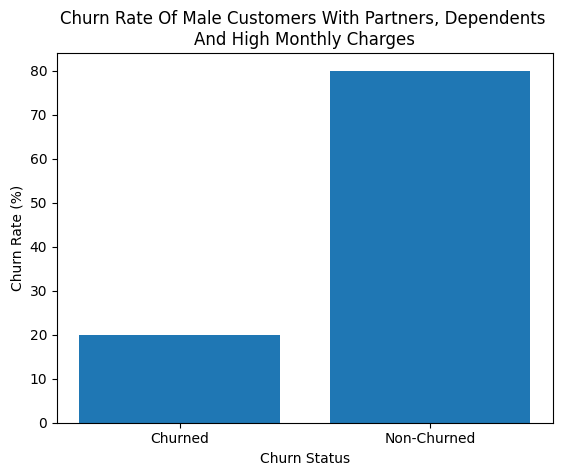

In [258]:
# Filter the data to include only male customers with partners and dependents and high monthly charges
filtered_train_data = train_data[(train_data['gender'] == 'Male') & (train_data['Partner'] == 'Yes') & (train_data['Dependents'] == 'Yes') & (train_data['MonthlyCharges'] > 100)]

# Calculate the churn rate.
rate_churned = filtered_train_data[filtered_train_data['Churn'] == 1].shape[0]/len(filtered_train_data) * 100

# Calculate the non-churn rate.
rate_non_churned = filtered_train_data[filtered_train_data['Churn'] == 0].shape[0]/len(filtered_train_data) * 100

# Display the result
print(f'Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: {rate_churned}%')
print(f'Non-Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: {rate_non_churned}%')

# Create a bar plot to visualize the churn rate and non-churn rate.
labels = ['Churned', 'Non-Churned']
charges = [rate_churned, rate_non_churned]

# Plot the churn rate of male customers with partners, dependents and high monthly charges
plt.bar(labels, charges)
plt.xlabel('Churn Status')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate Of Male Customers With Partners, Dependents \nAnd High Monthly Charges')
plt.show()

On the assumption that male customers with partners and dependents have higher financial demands to meet under average conditions, this question analyzed the rate at which high charges influenced the churn rate of this set of customers. It was discovered that only 20% of male customers with partners, dependents and high monthly charges churned. This confirms that the charges are not the only determinant of churn. There are other factors that greatly influenced the churn rate.

# Question 6
What is the churn rate of customers without online security?

Churn Rate Of Customers Without Online Security: 31.27962085308057%


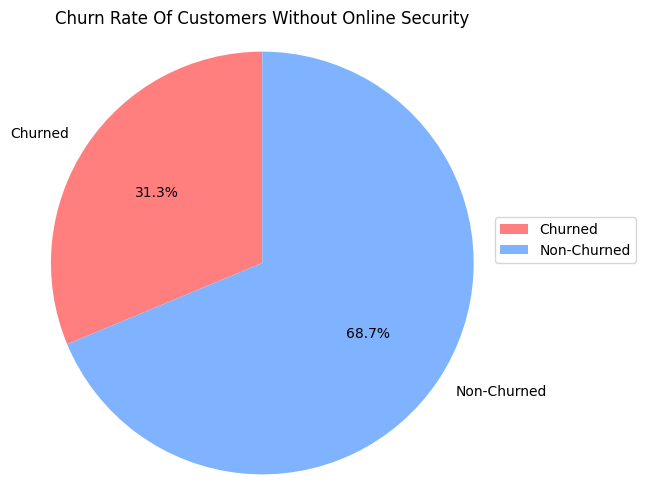

In [259]:
# Filter the DataFrame to include only customers without online security
no_security_customers = train_data[train_data['OnlineSecurity'] == 'No']

# Calculate the churn rate of customers without online security
churned_customers = no_security_customers[no_security_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_security_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Online Security: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without online security
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Online Security')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('Churn Rate Of Customers Without Online Security.png')

# Display the chart
plt.show()

31.3% of customers without online security churned. This means that the absence of online security influenced the churn rate of customers.

# Question 7
What is the churn rate of customers without online backup?

Churn Rate Of Customers Without Online Backup: 29.205678042887346%


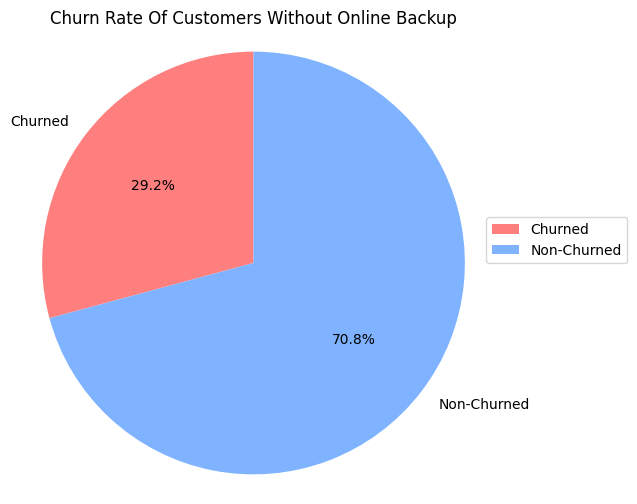

In [260]:
# Filter the DataFrame to include only customers without online backup
no_backup_customers = train_data[train_data['OnlineBackup'] == 'No']

# Calculate the churn rate of customers without online backup
churned_customers = no_backup_customers[no_backup_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_backup_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Online Backup: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without online backup
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Online Backup')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('Churn Rate Of Customers Without Online Backup.png')

# Display the chart
plt.show()

29.2% of customers without online backup churned. This means that the absence of online backup influenced the churn rate of customers.

# Question 8
What is the churn rate of customers without device protection?

Churn Rate Of Customers Without Device Protection: 28.58441952106699%


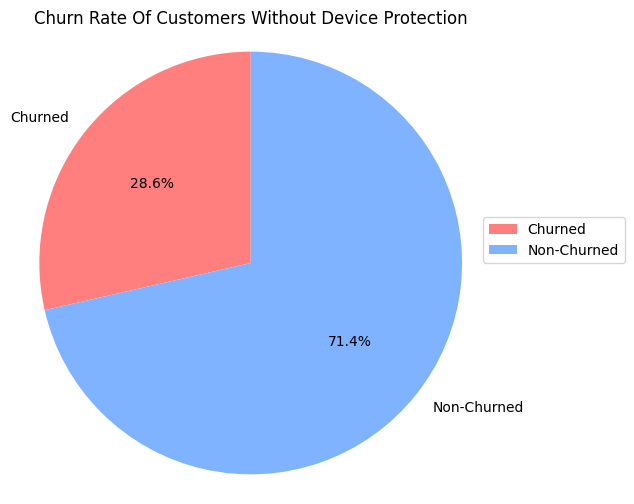

In [261]:
# Filter the DataFrame to include only customers without device protection
no_device_protection_customers = train_data[train_data['DeviceProtection'] == 'No']

# Calculate the churn rate of customers without device protection
churned_customers = no_device_protection_customers[no_device_protection_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_device_protection_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Device Protection: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without device protection
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Device Protection')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('Churn Rate Of Customers Without Device Protection.png')

# Display the chart
plt.show()

28.6% of customers without device protection churned. This means that the absence of device protection influenced the churn rate of customers.

# Question 9
What is the churn rate of customers without Tech support?

Churn Rate Of Customers Without Tech Support: 31.390765765765767%


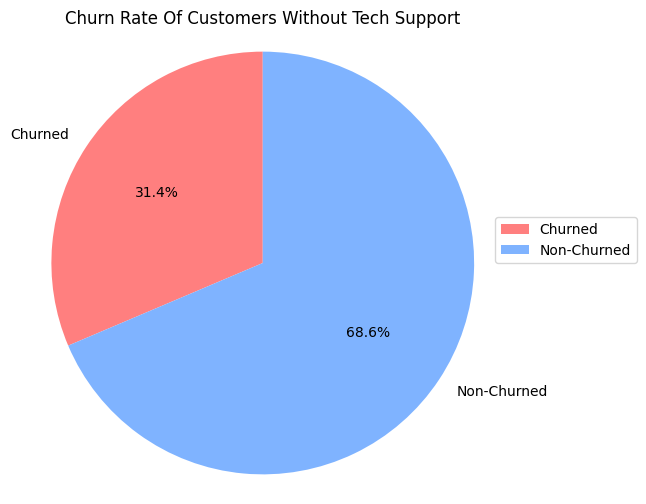

In [262]:
# Filter the DataFrame to include only customers without Tech support
no_tech_support_customers = train_data[train_data['TechSupport'] == 'No']

# Calculate the churn rate of customers without Tech support
churned_customers = no_tech_support_customers[no_tech_support_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_tech_support_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Tech Support: {churned_rate}%')

# Create a pie chart to visualize the result
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without Tech support
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Tech Support')
plt.legend(loc=(1,0.5))

# Save the chart as an image file
# plt.savefig('Churn Rate Of Customers Without Tech Support.png')

# Display the chart
plt.show()

31.4% of customers without Tech support churned. This means that the absence of Tech support influenced the churn rate of customers.

# Question 10
How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?

Churn Percentage Of Customers Without Online Security: 83.98203592814372%
Churn Percentage Of Customers Without Online Backup: 72.38023952095809%
Churn Percentage Of Customers Without Device Protection: 70.58383233532935%
Churn Percentage Of Customers Without Tech Support: 83.45808383233533%


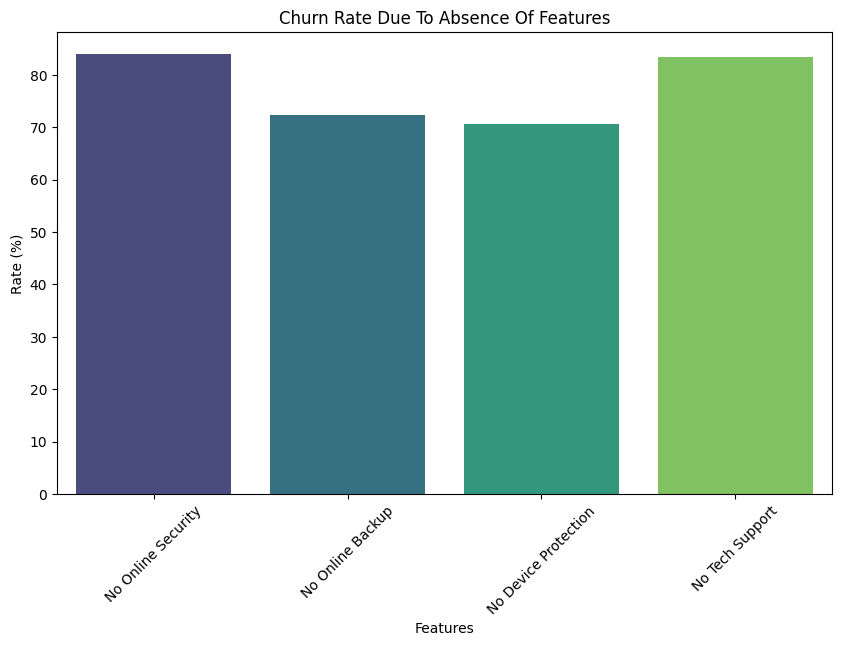

In [263]:
# Calculate the number of churned customers based on absence of each feature
churned_customers = train_data[train_data['Churn'] == 1]

absence_of_security = churned_customers[churned_customers['OnlineSecurity'] == 'No'].shape[0]
absence_of_backup = churned_customers[churned_customers['OnlineBackup'] == 'No'].shape[0]
absence_of_protection = churned_customers[churned_customers['DeviceProtection'] == 'No'].shape[0]
absence_of_tech_support = churned_customers[churned_customers['TechSupport'] == 'No'].shape[0]

# Calculate the rate at which the absence of each feature contributes to churning
total_churned_customers = churned_customers.shape[0]

rate_of_security = (absence_of_security / total_churned_customers) * 100
rate_of_backup = (absence_of_backup / total_churned_customers) * 100
rate_of_protection = (absence_of_protection / total_churned_customers) * 100
rate_of_tech_support = (absence_of_tech_support / total_churned_customers) * 100

# Display the results
print(f'Churn Percentage Of Customers Without Online Security: {rate_of_security}%')
print(f'Churn Percentage Of Customers Without Online Backup: {rate_of_backup}%')
print(f'Churn Percentage Of Customers Without Device Protection: {rate_of_protection}%')
print(f'Churn Percentage Of Customers Without Tech Support: {rate_of_tech_support}%')

# Create a bar plot to visualize the results
labels = ['No Online Security', 'No Online Backup', 'No Device Protection', 'No Tech Support']
rates = [rate_of_security, rate_of_backup, rate_of_protection, rate_of_tech_support]

# Plot the rate at which the absence of each feature contributes to churning
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=rates, palette='viridis')
plt.title('Churn Rate Due To Absence Of Features')
plt.xlabel('Features')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.show()

This means that out of all the churned customers, 84.0% did not have online security, 72.4% did not have online backup, 70.6% did not have device protection, and 83.5% did not have Tech support. These factors are majorly responsible for churning.

# Question 11
How does the length of customers' contract affect their likelihood of churn?

Contract Lengths: ['Month-to-month' 'One year' 'Two year']
Churn Rates: [43.14868804664723, 11.563981042654028, 2.4115755627009645]


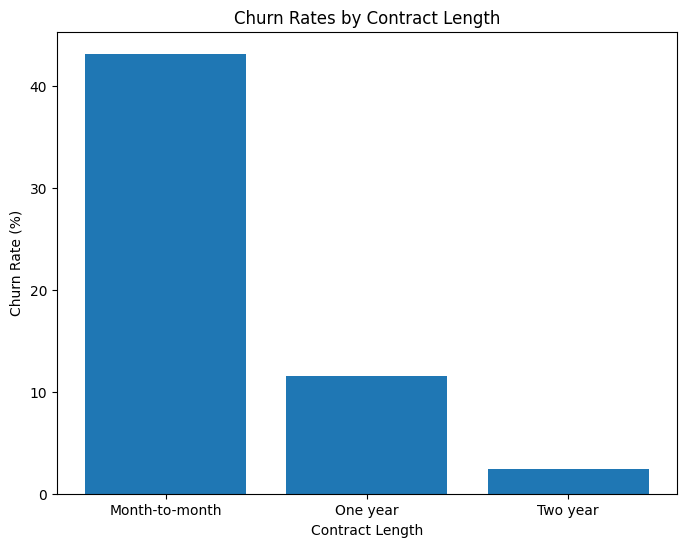

In [264]:
# Calculate churn rates for different contract lengths
contract_lengths = train_data['Contract'].unique()
churn_rates = []

for length in contract_lengths:
   churn_rate = train_data[train_data['Contract'] == length]['Churn'].value_counts(normalize=True).get(1, 0) * 100
   churn_rates.append(churn_rate)

# Display the contract lenghts and churn rates
print(f'Contract Lengths: {contract_lengths}')
print(f'Churn Rates: {churn_rates}')

# Create a bar plot to visualize the churn rates by contract length
plt.figure(figsize=(8, 6))
plt.bar(contract_lengths, churn_rates)
plt.xlabel('Contract Length')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rates by Contract Length')
plt.show()

As shown, the length of a customer's contract affects the churn rate. Customers with month-to-month contract have a high churn rate of 43.1%. This is followed by customers with one year contract length with a churn rate of 11.6%. While customers with two year contract length have a low churn rate of 2.4%.

# Question 12
How does the length of customers' tenure affect their likelihood of churn?

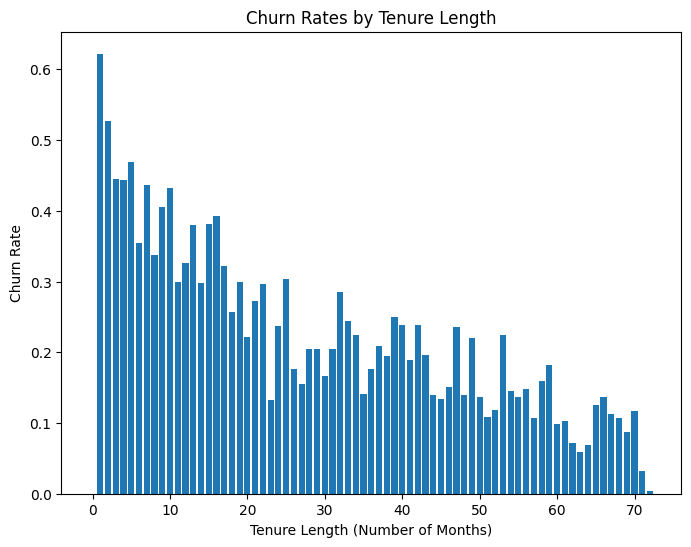

In [265]:
# Calculate churn rates for different tenure lengths
tenure_lengths = train_data['tenure'].unique()
churn_rates = []

for length in tenure_lengths:
   churn_rate = train_data[train_data['tenure'] == length]['Churn'].value_counts(normalize=True).get(1, 0)
   churn_rates.append(churn_rate)

# Create a bar plot to visualize the churn rates by tenure length
plt.figure(figsize=(8, 6))
plt.bar(tenure_lengths, churn_rates)
plt.xlabel('Tenure Length (Number of Months)')
plt.ylabel('Churn Rate')
plt.title('Churn Rates by Tenure Length')

# Save the chart as an image file
# plt.savefig('Churn Rates by Tenure Length.png')

# Display the chart
plt.show()

As shown, the more the tenure length (number of months) a customer stays with the telecommunication company, the lower the likelihood of churn. This is ralated to the result of the likelihood of churn based on the contract length of customers.

# Conclusion

1. The absence of online security, online backup, device protection and Tech support contributed greatly to the churn rate of the telecommunication company.

2. There was a high churn rate among new customers (that is, customers with low tenure lengths) as well as customers with short-term contracts (that is, month-to-month contracts and one year contracts respectively).

# Recommendations

1. The Tech team of the company should work towards the provision of online security, online backup, device protection and Tech support to the customers that lack these services to ensure customer satisfaction and retention.

2. If the customers without these online services do not have internet-enabled devices, the company can introduce promotional campaigns that will enable these customers win internet-enabled devices while increasing their patronage and suscribing for long-term (two year) contracts.
Note: The internet-enabled devices to be won can be carrier-locked. This means that the devices can be programmed to work only with the company's network or carrier. This will lead to customer retention/longevity while combating the activities of competitors.

3. Juicy promotional offers should be introduced to new customers to motivate their longevity with the company and match offers from competitors. This could be in form of bonus packages for long-term suscriptions.

# Pandas Profiling

Pandas profiling is an open-source Python library that generates a comprehensive report that provides detailed insights and statistical summaries about the structure, distributions, correlations, missing values, and other characteristics of a dataset. It is important in machine learning for Exploratory Data Analysis (EDA) and data preprocessing.

The report generated through pandas profiling enhances data understanding and the detection of anomalies in the dataset. This gives room for quality data cleaning and informed feature selection leading to an improved Machine Learning process.

In [266]:
# Pandas Profiling on train dataset

profile = ProfileReport(train_data, title = "Train Dataset", html = {'style': {'full_width': True}})
profile.to_notebook_iframe()
profile.to_file('(Trainset) Pandas-Profiling_Report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

Feature engineering is the process that selects and transforms raw data from datasets into the desired features that can be used in supervised learning for modelling.

In order to preserve the original cleaned datasets for future analysis, a copy of the train and test datasets will be created and used feature engineering.

Also, in order to avoid data leakage the copy of the train dataset created will be splitted to obtain the training set and the validation set before feature engineering processes are carried out.

In [267]:
# Create a copy of the train and test datasets on which to carry out the feature engineering processes

train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

In [268]:
# Split the copy of the train dataset

X = train_data_copy.drop('Churn', axis=1)
y = train_data_copy['Churn']

# Split train dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the train dataset
print("Train set shape:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Train set shape: (4034, 19) (4034,) (1009, 19) (1009,)


In [269]:
# Obtain the categorical and numerical columns of X_train
X_train_cat = X_train.select_dtypes(include=['object']).columns
X_train_num = X_train.select_dtypes(include=['float64', 'int64']).columns
# Create seperate DataFrames for categorical columns and numerical columns of X_train
X_train_cat_df = X_train[X_train_cat]
X_train_num_df = X_train[X_train_num]

# Obtain the categorical and numerical columns of X_val
X_val_cat = X_val.select_dtypes(include=['object']).columns
X_val_num = X_val.select_dtypes(include=['float64', 'int64']).columns
# Create seperate DataFrames for categorical columns and numerical columns of X_val
X_val_cat_df = X_val[X_val_cat]
X_val_num_df = X_val[X_val_num]

# Obtain the categorical and numerical columns of the test dataset
test_cat = test_data.select_dtypes(include=['object']).columns
test_num = test_data.select_dtypes(include=['float64', 'int64']).columns
# Create seperate DataFrames for categorical columns and numerical columns of the test dataset
test_cat_df = test_data_copy[test_cat]
test_num_df = test_data_copy[test_num]

### Feature encoding

Since the values of the churn column in the train dataset were changed from 'Yes' and 'No' to 1 and 0 respectively to aid the calculations used to answer the analytical questions, and scaling has been applied to the numerical columns of both train and test datasets, it is important to relist the numerical and categorical columns of both datasets.

In [270]:
# Create an encoder object using OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop="first")

In [271]:
# Use OneHotEncoder to encode the categorical columns of X_train
encoder.fit(X_train_cat_df)
X_train_cat_encoded = encoder.transform(X_train_cat_df).tolist()
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out())

# View the encoded X_train DataFrame
X_train_cat_encoded_df.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [272]:
# Use OneHotEncoder to encode the categorical columns of X_val
encoder.fit(X_val_cat_df)
X_val_cat_encoded = encoder.transform(X_val_cat_df).tolist()
X_val_cat_encoded_df = pd.DataFrame(X_val_cat_encoded, columns=encoder.get_feature_names_out())

# View the encoded X_val DataFrame
X_val_cat_encoded_df.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [273]:
# Use OneHotEncoder to encode the categorical columns of the test dataset
encoder.fit(test_cat_df)
test_cat_encoded = encoder.transform(test_cat_df).tolist()
test_cat_encoded_df = pd.DataFrame(test_cat_encoded, columns=encoder.get_feature_names_out())

# View the encoded test DataFrame
test_cat_encoded_df.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Feature scaling

Feature scaling is a data preprocessing technique that involves transforming the values of features or variables in a dataset to a similar scale. This is to ensure that all features contribute equally to the training of models and to prevent features with larger values from dominating the models trained.

In [274]:
# Create a scaler object using StandardScaler

scaler = StandardScaler()

In [275]:
# Use StandardScaler to scale the numerical columns of X_train
X_train_num_scaled = scaler.fit_transform(X_train_num_df)
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=scaler.get_feature_names_out())

# View the scaled X_train DataFrame
X_train_num_scaled_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-0.107406,0.668918,0.109882
1,-0.515543,-1.524645,-0.861047
2,-1.127747,0.673885,-0.827412
3,0.668053,-1.473324,-0.563382
4,1.606766,0.844403,1.872987


In [276]:
# Use StandardScaler to scale the numerical columns of X_val
X_val_num_scaled = scaler.fit_transform(X_val_num_df)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=scaler.get_feature_names_out())

# View the scaled X_val DataFrame
X_val_num_scaled_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-0.095692,0.462249,0.067721
1,0.919377,0.838459,1.257842
2,1.284803,1.616299,2.203685
3,1.244200,0.538508,1.226619
4,-0.339309,-0.493528,-0.447825


In [277]:
# Use StandardScaler to scale the numerical columns of the test dataset
test_num_scaled = scaler.fit_transform(test_num_df)
test_num_scaled_df = pd.DataFrame(test_num_scaled, columns=scaler.get_feature_names_out())

# View the scaled test Dataframe
test_num_scaled_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-0.806164,0.680954,-0.521120
1,-0.927983,-1.444882,-0.909929
2,-0.197064,0.589681,-0.010385
3,-0.197064,0.516662,-0.024560
4,-1.252836,0.836948,-0.950969


In [278]:
# Concatenate the encoded X_train DataFrame and the scaled X_train DataFrame to have the unbalanced X_train DataFrame

X_train = pd.concat([X_train_cat_encoded_df, X_train_num_scaled_df.set_axis(X_train_cat_encoded_df.index)], axis=1)
X_train.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.107406,0.668918,0.109882
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.515543,-1.524645,-0.861047
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.127747,0.673885,-0.827412
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.668053,-1.473324,-0.563382
4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.606766,0.844403,1.872987


In [279]:
# Concatenate the encoded X_val DataFrame and the scaled X_val DataFrame to have the ready X_val DataFrame

X_val = pd.concat([X_val_cat_encoded_df, X_val_num_scaled_df.set_axis(X_val_cat_encoded_df.index)], axis=1)
X_val.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,-0.095692,0.462249,0.067721
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.919377,0.838459,1.257842
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.284803,1.616299,2.203685
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.244200,0.538508,1.226619
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.339309,-0.493528,-0.447825


In [280]:
# Concatenate the encoded test DataFrame and the scaled test DataFrame to have the transformed test DataFrame

test_ready = pd.concat([test_cat_encoded_df, test_num_scaled_df.set_axis(test_cat_encoded_df.index)], axis=1)
test_ready.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.806164,0.680954,-0.521120
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.927983,-1.444882,-0.909929
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.197064,0.589681,-0.010385
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.197064,0.516662,-0.024560
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.252836,0.836948,-0.950969


# Balance the X_train dataset

In [281]:
# Perform oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Perform undersampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

# Print the class distribution before and after balancing
print("Before balancing:")
print(y_train.value_counts())

print("After balancing:")
print(pd.Series(y_train_balanced).value_counts())

Before balancing:
Churn
0    2965
1    1069
Name: count, dtype: int64
After balancing:
Churn
0    1069
1    1069
Name: count, dtype: int64


# Model Training and Evaluation

In [282]:
# Create a list of models to train and evaluate
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Adaptive Boosting', AdaBoostClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier())
]

### Model training and evaluation with unbalanced dataset

In [283]:
# Create an empty dictionary to store the performance metrics of the models after training with unbalanced dataset
unbal_performance_metrics = {}

# Model training, evaluation and result calculation
for model_name, model in models:
    # Model training with unbalanced dataset
    model.fit(X_train, y_train)
    
    # Using the models to make predictions on the validation set
    y_pred_unbal = model.predict(X_val)
    
    # Calculate the performance metrics of the models on the balanced dataset
    accuracy = accuracy_score(y_val, y_pred_unbal)
    precision = precision_score(y_val, y_pred_unbal)
    recall = recall_score(y_val, y_pred_unbal)
    f1 = f1_score(y_val, y_pred_unbal)
    roc_auc = roc_auc_score(y_val, y_pred_unbal)
    
    # Store the performance metrics results
    unbal_performance_metrics[model_name] = {
        'Unbal Accuracy': accuracy,
        'Unbal Precision': precision,
        'Unbal Recall': recall,
        'Unbal F1 Score': f1,
        'Unbal ROC_AUC': roc_auc
    }

In [284]:
# Create a DataFrame to store the performance metrics of the models on the unbalanced dataset
unbalanced_performance_metrics = pd.DataFrame(unbal_performance_metrics).transpose()
    
# Arrange the performance metrics DataFrame in descending order according to the F1 Score
unbalanced_performance_metrics = unbalanced_performance_metrics.sort_values('Unbal F1 Score', ascending=False)

# Show the performance metrics DataFrame of the models on the unbalanced dataset
unbalanced_performance_metrics.style.set_caption('The Performance Metrics Of The Models On The Unbalanced Dataset')

,Unbal Accuracy,Unbal Precision,Unbal Recall,Unbal F1 Score,Unbal ROC_AUC
Gaussian Naive Bayes,0.744301,0.510949,0.786517,0.619469,0.757814
Adaptive Boosting,0.802775,0.638211,0.588015,0.612086,0.734034
Logistic Regression,0.799802,0.632653,0.580524,0.605469,0.729615
Support Vector Machine,0.805748,0.662100,0.543071,0.596708,0.721670
Gradient Boosting,0.790882,0.614754,0.561798,0.587084,0.717557
Random Forest,0.791873,0.626667,0.528090,0.573171,0.707441
K-Nearest Neighbors,0.774034,0.575875,0.554307,0.564885,0.703703
Decision Tree,0.720515,0.475248,0.539326,0.505263,0.662520


Based on the f1 score of the models, Guassian Naive Bayes is the best model for the unbalanced dataset with an f1 score of 0.618557.

### Confusion matrix for unbalanced dataset

Confusion Matrix For Logistic Regression On Unbalanced Dataset:
[[652  90]
 [112 155]]


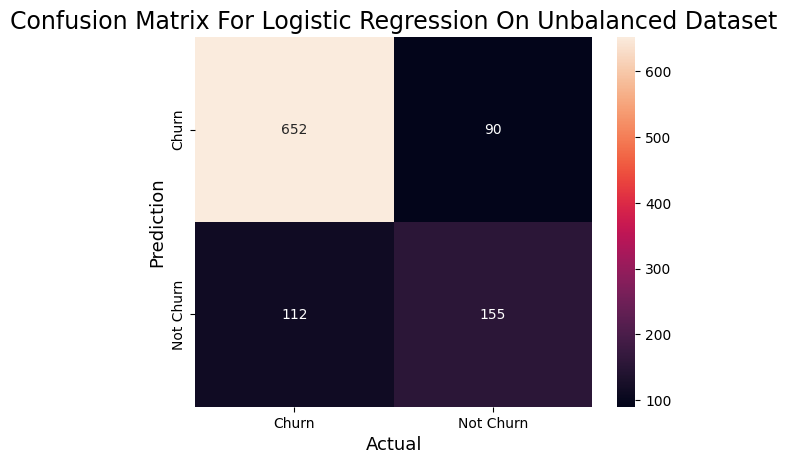

Confusion Matrix For Decision Tree On Unbalanced Dataset:
[[583 159]
 [123 144]]


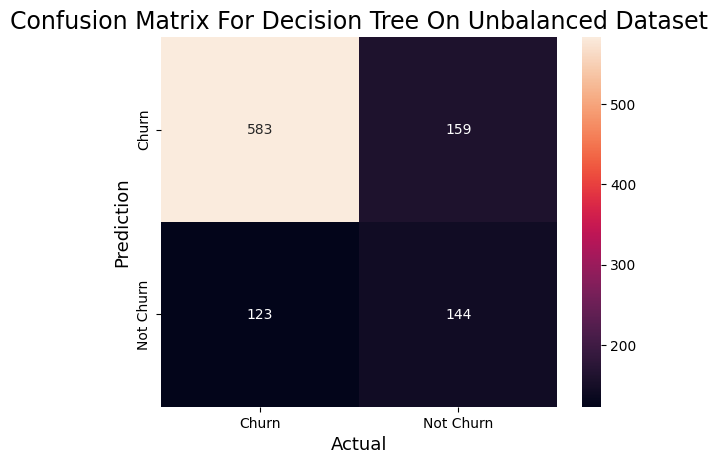

Confusion Matrix For Random Forest On Unbalanced Dataset:
[[658  84]
 [126 141]]


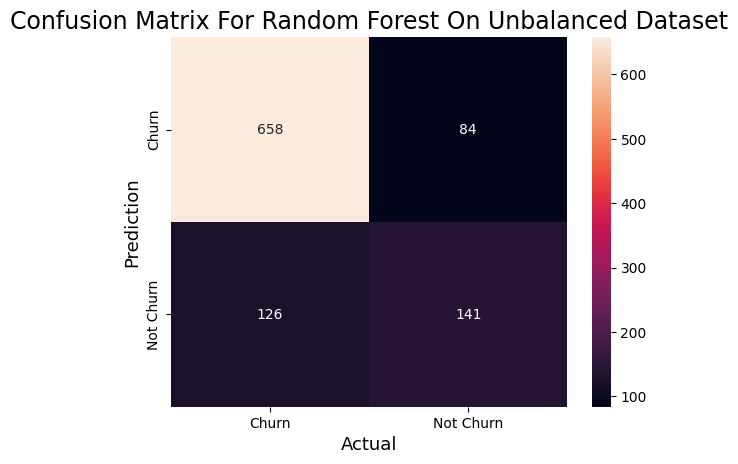

Confusion Matrix For Gradient Boosting On Unbalanced Dataset:
[[648  94]
 [117 150]]


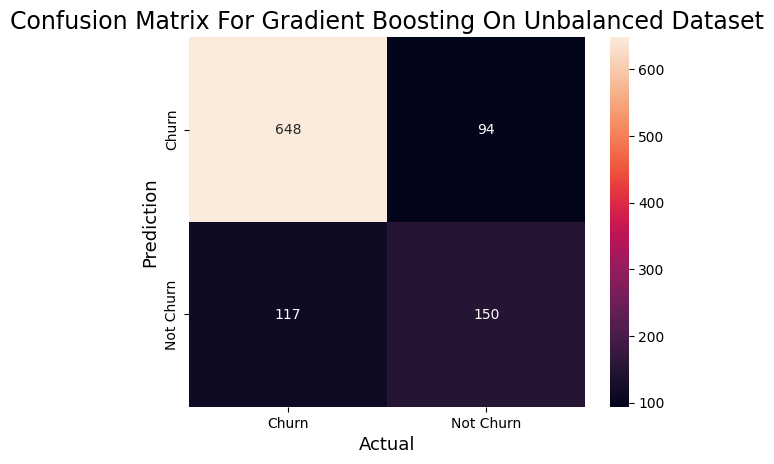

Confusion Matrix For Adaptive Boosting On Unbalanced Dataset:
[[653  89]
 [110 157]]


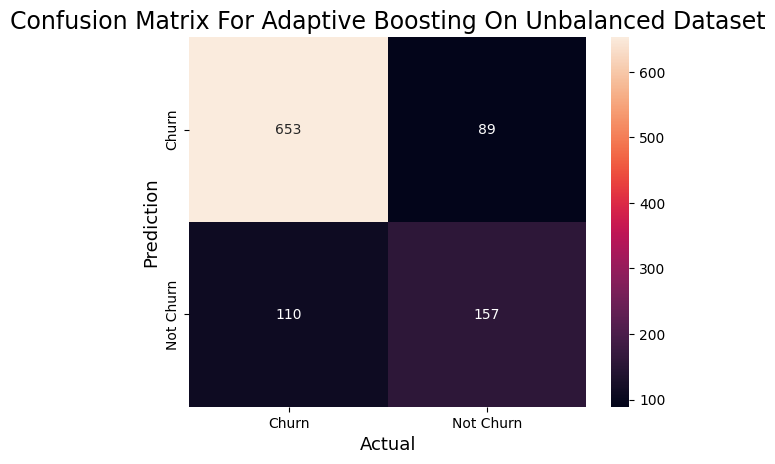

Confusion Matrix For Support Vector Machine On Unbalanced Dataset:
[[668  74]
 [122 145]]


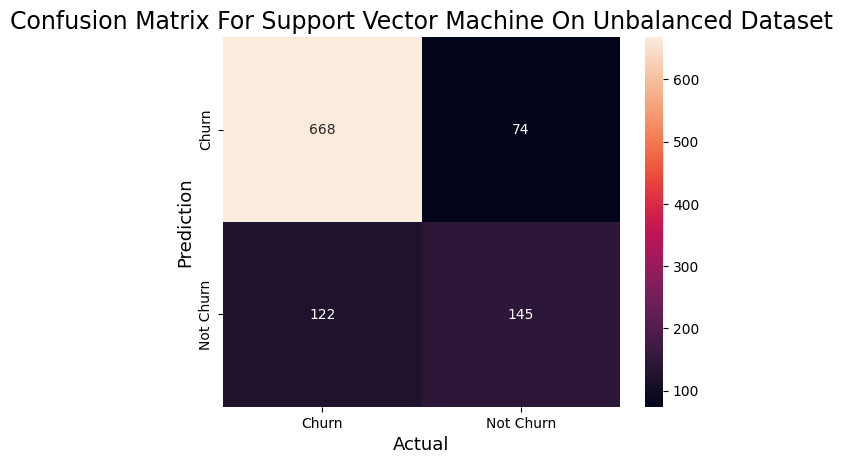

Confusion Matrix For Gaussian Naive Bayes On Unbalanced Dataset:
[[541 201]
 [ 57 210]]


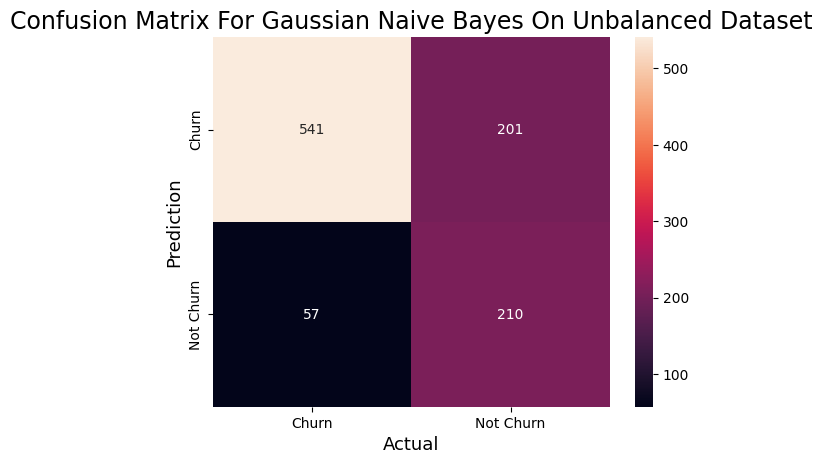

Confusion Matrix For K-Nearest Neighbors On Unbalanced Dataset:
[[633 109]
 [119 148]]


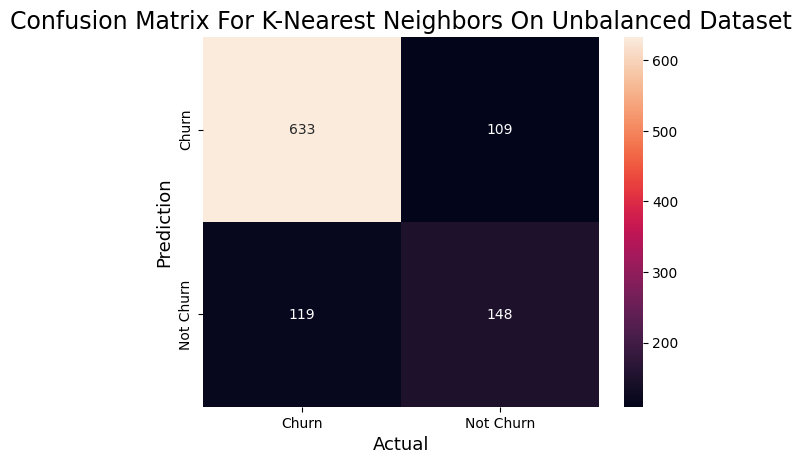

In [285]:
# Model prediction and confusion matrix computation
for model_name, model in models:
    # Model training with unbalanced dataset
    model.fit(X_train, y_train)
    
    # Using the models to make predictions on the validation set
    y_pred_unbal = model.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_pred_unbal)
    
    # Print the confusion matrix
    print(f'Confusion Matrix For {model_name} On Unbalanced Dataset:\n{cm}')
    
    # plot the confusion matrix
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Churn','Not Churn'],
            yticklabels=['Churn','Not Churn'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title(f'Confusion Matrix For {model_name} On Unbalanced Dataset',fontsize=17)
    plt.show()

### Model training and evaluation with balanced dataset

In [286]:
# Create an empty dictionary to store the performance metrics of the models after training with balanced dataset

bal_performance_metrics = {}

# Model training, evaluation and result calculation
for model_name, model in models:
    # Model training with balanced dataset
    model.fit(X_train_balanced, y_train_balanced)
    
    # Using the models to make predictions on the validation set
    y_pred_bal = model.predict(X_val)
    
    # Calculate the performance metrics of the models on the balanced dataset
    accuracy = accuracy_score(y_val, y_pred_bal)
    precision = precision_score(y_val, y_pred_bal)
    recall = recall_score(y_val, y_pred_bal)
    f1 = f1_score(y_val, y_pred_bal)
    roc_auc = roc_auc_score(y_val, y_pred_bal)
    
    # Store the performance metrics results
    bal_performance_metrics[model_name] = {
        'Bal Accuracy': accuracy,
        'Bal Precision': precision,
        'Bal Recall': recall,
        'Bal F1 Score': f1,
        'Bal ROC_AUC': roc_auc
    }

In [287]:
# Create a DataFrame to store the performance metrics of the models on the balanced dataset
balanced_performance_metrics = pd.DataFrame(bal_performance_metrics).transpose()
    
# Arrange the performance metrics DataFrame in descending order according to the F1 Score
balanced_performance_metrics = balanced_performance_metrics.sort_values('Bal F1 Score', ascending=False)

# Show the performance metrics DataFrame of the models on the balanced dataset
balanced_performance_metrics.style.set_caption('The Performance Metrics Of The Models On The Balanced Dataset')

,Bal Accuracy,Bal Precision,Bal Recall,Bal F1 Score,Bal ROC_AUC
Adaptive Boosting,0.750248,0.517084,0.850187,0.643059,0.782236
Random Forest,0.743310,0.509709,0.786517,0.618557,0.757140
Gradient Boosting,0.744301,0.511002,0.782772,0.618343,0.756615
Support Vector Machine,0.736373,0.501193,0.786517,0.612245,0.752423
Logistic Regression,0.731417,0.495327,0.794007,0.610072,0.751451
Gaussian Naive Bayes,0.720515,0.483370,0.816479,0.607242,0.751232
K-Nearest Neighbors,0.693756,0.455319,0.801498,0.580733,0.728242
Decision Tree,0.690783,0.446043,0.696629,0.543860,0.692654


As can be observed, the models performed better generally on the balanced dataset than on the unbalanced dataset.

Based on the f1 score of the models, AdaBoost is the best model with an f1 score of 0.641457.

### Confusion matrix for balanced dataset

Confusion Matrix For Logistic Regression On Balanced Dataset:
[[526 216]
 [ 55 212]]


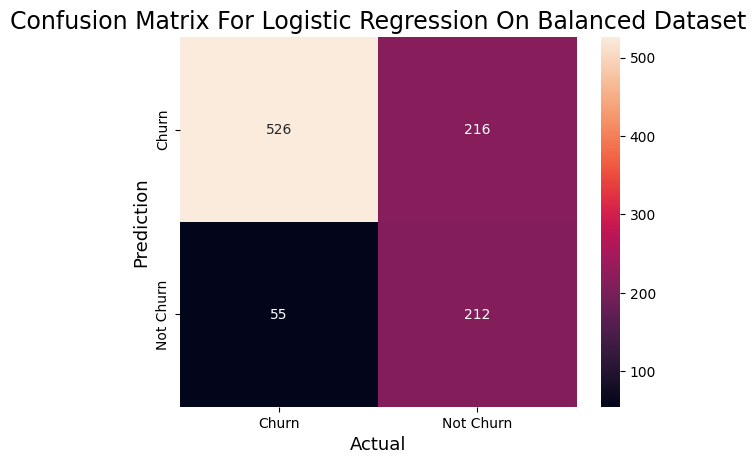

Confusion Matrix For Decision Tree On Balanced Dataset:
[[511 231]
 [ 81 186]]


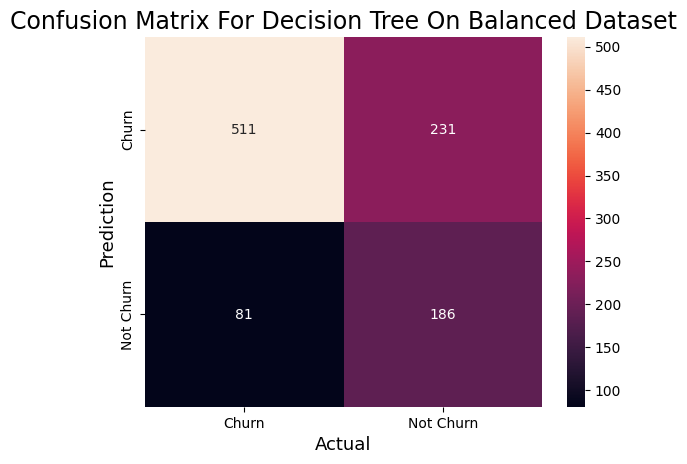

Confusion Matrix For Random Forest On Balanced Dataset:
[[540 202]
 [ 57 210]]


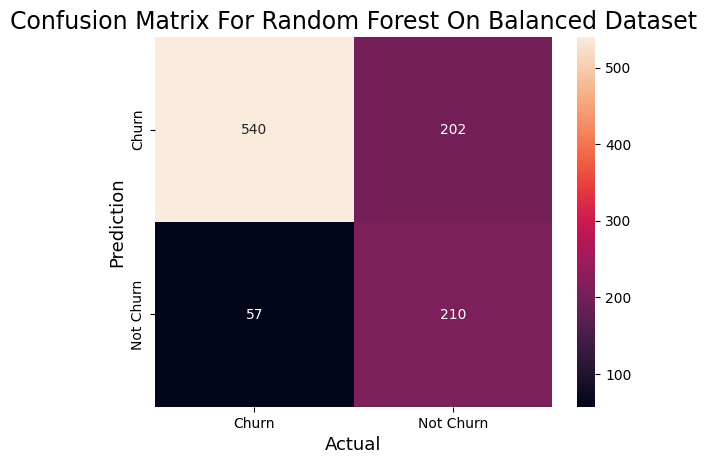

Confusion Matrix For Gradient Boosting On Balanced Dataset:
[[542 200]
 [ 58 209]]


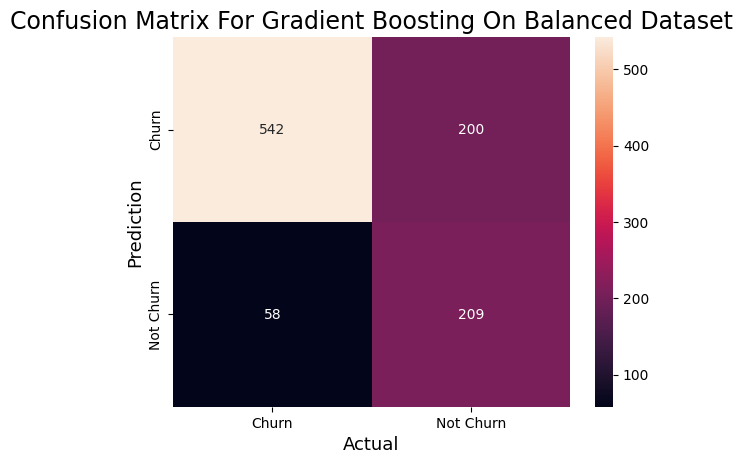

Confusion Matrix For Adaptive Boosting On Balanced Dataset:
[[530 212]
 [ 40 227]]


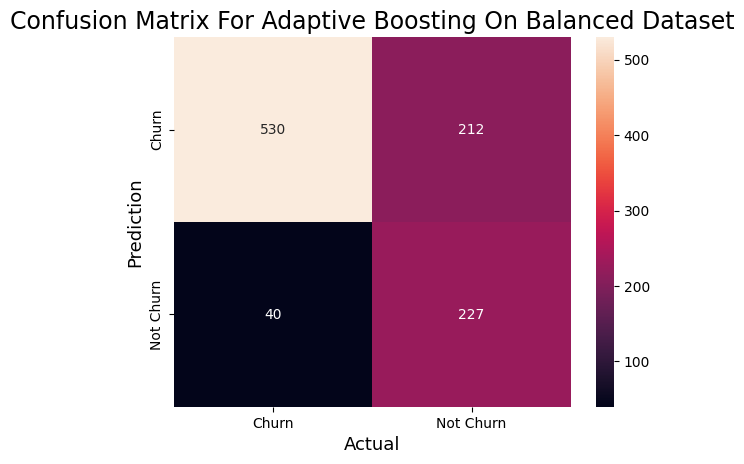

Confusion Matrix For Support Vector Machine On Balanced Dataset:
[[533 209]
 [ 57 210]]


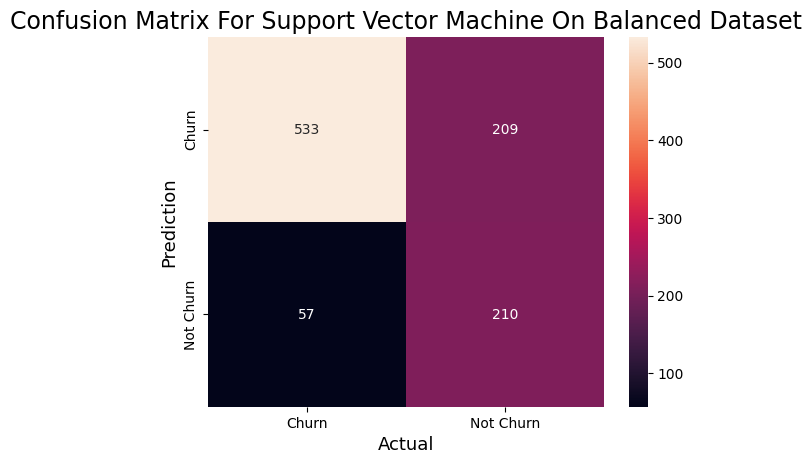

Confusion Matrix For Gaussian Naive Bayes On Balanced Dataset:
[[509 233]
 [ 49 218]]


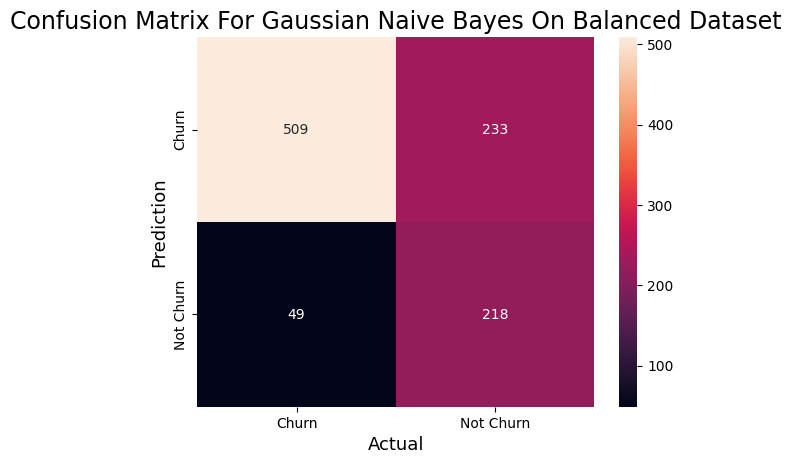

Confusion Matrix For K-Nearest Neighbors On Balanced Dataset:
[[486 256]
 [ 53 214]]


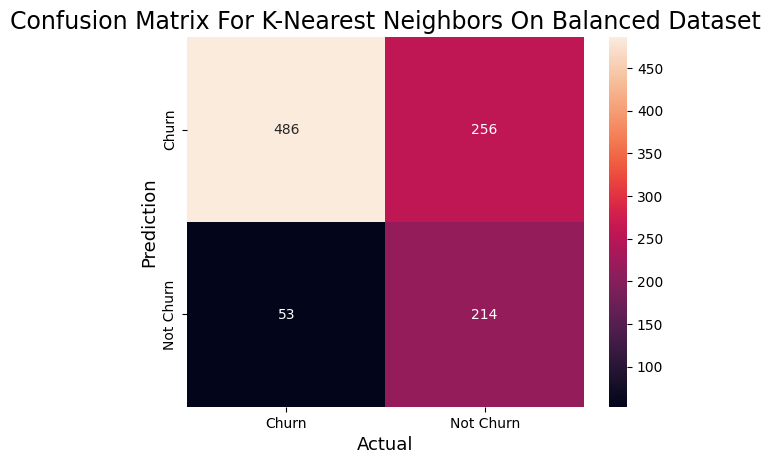

In [288]:
# Model prediction and confusion matrix computation
for model_name, model in models:
    # Model training with balanced dataset
    model.fit(X_train_balanced, y_train_balanced)
    
    # Using the models to make predictions on the validation set
    y_pred_bal = model.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_pred_bal)
    
    # Print the confusion matrix
    print(f'Confusion Matrix For {model_name} On Balanced Dataset:\n{cm}')
    
    # plot the confusion matrix
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Churn','Not Churn'],
            yticklabels=['Churn','Not Churn'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title(f'Confusion Matrix For {model_name} On Balanced Dataset',fontsize=17)
    plt.show()

# Hyperparameter tuning

Hyperparameters are adjustable parameters whose values control the model training process.

Hyperparameter tuning (or hyperparameter optimization) is a process used to determine the right combination of hyperparameters that maximizes the model performance. It works by running multiple trials in a single training process. The hyperparameters are set within specified limits and executed to identify the set of hyperparameter values that are best suited for a model to give optimal results.

In [289]:
# Get the available parameters for each model

for model_name, model in models:
    available_params = model.get_params()
    print(f'Available Parameters For {model_name}:{available_params}\n')

Available Parameters For Logistic Regression:{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Available Parameters For Decision Tree:{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

Available Parameters For Random Forest:{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_sc

In [290]:
# Create an empty dictionary to store the performance metrics of the tuned models on the balanced dataset
tun_bal_performance_metrics = {}

# Perform hyperparameter tuning
for model_name, model in models:
    params_selection = {
        'Logistic Regression' : {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'C': [100, 10, 1.0]},
        'Decision Tree' : {'max_depth': [1, 3], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
        'Random Forest' : {'n_estimators': [500, 700], 'max_depth': [1, 3]},
        'Gradient Boosting' : {'n_estimators': [100, 150],'learning_rate': [0.1, 1.0]},
        'Adaptive Boosting' : {'n_estimators': [10, 50],'learning_rate': [1.0, 5.0]},
        'Support Vector Machine' : {'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [100, 10, 1.0]},
        'Gaussian Naive Bayes' : {'var_smoothing': [float, 1e-09]},
        'K-Nearest Neighbors' : {'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
    }
   
    # Get the selected parameter values for the models to tune
    param_grid = params_selection[model_name]
    
    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=0, refit=True)
    grid_search.fit(X_train_balanced, y_train_balanced)
         
    # Get the best of each model with the best parameters
    best_params = grid_search.best_params_
    best_params_model = grid_search.best_estimator_
    
    # Show the best parameters for each model
    print(f'The best parameters for {model_name} are {best_params}\n')
    
    # Using each model with it's best parameters to make predictions on the validation set
    best_params_model.fit(X_train_balanced, y_train_balanced)
    y_pred_bal_tun = best_params_model.predict(X_val)
    
    # Calculate the performance metrics on the balanced dataset for each model with it's best parameters
    accuracy = accuracy_score(y_val, y_pred_bal_tun)
    precision = precision_score(y_val, y_pred_bal_tun)
    recall = recall_score(y_val, y_pred_bal_tun)
    f1 = f1_score(y_val, y_pred_bal_tun)
    roc_auc = roc_auc_score(y_val, y_pred_bal_tun)
    
    # Store the performance metrics results
    tun_bal_performance_metrics[model_name] = {
        'Tuned-Bal Accuracy': accuracy,
        'Tuned-Bal Precision': precision,
        'Tuned-Bal Recall': recall,
        'Tuned-Bal F1 Score': f1,
        'Tuned-Bal ROC_AUC': roc_auc
    }

The best parameters for Logistic Regression are {'C': 1.0, 'solver': 'newton-cg'}

The best parameters for Decision Tree are {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

The best parameters for Random Forest are {'max_depth': 3, 'n_estimators': 500}

The best parameters for Gradient Boosting are {'learning_rate': 0.1, 'n_estimators': 100}

The best parameters for Adaptive Boosting are {'learning_rate': 1.0, 'n_estimators': 50}

The best parameters for Support Vector Machine are {'C': 1.0, 'kernel': 'rbf'}

The best parameters for Gaussian Naive Bayes are {'var_smoothing': 1e-09}

The best parameters for K-Nearest Neighbors are {'metric': 'euclidean', 'weights': 'uniform'}



In [291]:
# Create a DataFrame to store the performance metrics of the tuned models on the balanced dataset
tuned_bal_performance_metrics = pd.DataFrame(tun_bal_performance_metrics).transpose()
    
# Arrange the performance metrics DataFrame in descending order according to the F1 Score
tuned_bal_performance_metrics = tuned_bal_performance_metrics.sort_values('Tuned-Bal F1 Score', ascending=False)

# Show the performance metrics DataFrame of the tuned models on the balanced dataset
tuned_bal_performance_metrics.style.set_caption('The Performance Metrics Of The Tuned Models On The Balanced Dataset')

,Tuned-Bal Accuracy,Tuned-Bal Precision,Tuned-Bal Recall,Tuned-Bal F1 Score,Tuned-Bal ROC_AUC
Adaptive Boosting,0.750248,0.517084,0.850187,0.643059,0.782236
Gradient Boosting,0.744301,0.511002,0.782772,0.618343,0.756615
Random Forest,0.735382,0.500000,0.794007,0.613603,0.754147
Support Vector Machine,0.736373,0.501193,0.786517,0.612245,0.752423
Logistic Regression,0.731417,0.495327,0.794007,0.610072,0.751451
Gaussian Naive Bayes,0.720515,0.483370,0.816479,0.607242,0.751232
K-Nearest Neighbors,0.693756,0.455319,0.801498,0.580733,0.728242
Decision Tree,0.638256,0.414336,0.887640,0.564958,0.718079


From the table above, Adaptive Boosting is the best model after balancing the datasets and carrying out hyperparameter tuning.

# Combine the performance metrics of the models

The performance metrics of the models obtained for the unbalanced dataset, the balanced dataset and the performance metrics obtained for the tuned models will be combined together respectively to easily evaluate how each model performed in the three conditions.

In [292]:
# Concatenate the DataFrames while preserving columns
combined_performance_metrics = pd.concat([unbalanced_performance_metrics, balanced_performance_metrics,
                                          tuned_bal_performance_metrics], axis=1)

# Arrange the combined performance metrics DataFrame in descending order according to the F1 Score of the tuned models
combined_performance_metrics = combined_performance_metrics.sort_values('Tuned-Bal F1 Score', ascending=False)

# Show the performance metrics DataFrame of the tuned models on the balanced dataset
combined_performance_metrics.style.set_caption('The Combined Performance Metrics Of The Models')

,Unbal Accuracy,Unbal Precision,Unbal Recall,Unbal F1 Score,Unbal ROC_AUC,Bal Accuracy,Bal Precision,Bal Recall,Bal F1 Score,Bal ROC_AUC,Tuned-Bal Accuracy,Tuned-Bal Precision,Tuned-Bal Recall,Tuned-Bal F1 Score,Tuned-Bal ROC_AUC
Adaptive Boosting,0.802775,0.638211,0.588015,0.612086,0.734034,0.750248,0.517084,0.850187,0.643059,0.782236,0.750248,0.517084,0.850187,0.643059,0.782236
Gradient Boosting,0.790882,0.614754,0.561798,0.587084,0.717557,0.744301,0.511002,0.782772,0.618343,0.756615,0.744301,0.511002,0.782772,0.618343,0.756615
Random Forest,0.791873,0.626667,0.528090,0.573171,0.707441,0.743310,0.509709,0.786517,0.618557,0.757140,0.735382,0.500000,0.794007,0.613603,0.754147
Support Vector Machine,0.805748,0.662100,0.543071,0.596708,0.721670,0.736373,0.501193,0.786517,0.612245,0.752423,0.736373,0.501193,0.786517,0.612245,0.752423
Logistic Regression,0.799802,0.632653,0.580524,0.605469,0.729615,0.731417,0.495327,0.794007,0.610072,0.751451,0.731417,0.495327,0.794007,0.610072,0.751451
Gaussian Naive Bayes,0.744301,0.510949,0.786517,0.619469,0.757814,0.720515,0.483370,0.816479,0.607242,0.751232,0.720515,0.483370,0.816479,0.607242,0.751232
K-Nearest Neighbors,0.774034,0.575875,0.554307,0.564885,0.703703,0.693756,0.455319,0.801498,0.580733,0.728242,0.693756,0.455319,0.801498,0.580733,0.728242
Decision Tree,0.720515,0.475248,0.539326,0.505263,0.662520,0.690783,0.446043,0.696629,0.543860,0.692654,0.638256,0.414336,0.887640,0.564958,0.718079


# Exportation

The key Machine Learning objects, including the best model, will be exported and used later to develop an app. 

In [311]:
# Store the best model instance of each model in the best_models dictionary
best_models[model_name] = best_params_model

# Initialize variables to track the best F1 score and the corresponding best model_name
best_f1_score = 0.0
best_model_name = None

# Iterate through the models and their F1 scores
for model_name, metrics in tun_bal_performance_metrics.items():
    f1_score = metrics['Tuned-Bal F1 Score']
    
    # Update the best model_name if the current model has a higher F1 score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_model_name = model_name

# Display the best model_name with the highest F1 score
print(f'The best model based on F1 score is: {best_model_name}')


# Retrieve the best model instance based on the best_model_name
best_model_instance = best_models[best_model_name]

The best model based on F1 score is: Adaptive Boosting


In [312]:
# Create a dictionary to store all the Machine Learning components

model_components = {
    'model': best_params_model,
    'encoder': encoder,
    'scaler': scaler
}

In [313]:
# Create an export folder named 'export'

!mkdir export

In [314]:
# Create a path to the export folder

destination = os.path.join('.', 'export')

In [315]:
# Save the components to a file using pickle

with open (os.path.join(destination, 'ml_components.pkl'), 'wb') as f:
    pickle.dump(model_components, f)

In [316]:
# Create requirements.txt file in export folder to describe the virtual environment used for the Machine Learning processes

!pip freeze > export/requirements.txt

In [317]:
# Zip the export folder and name the zipped export folder as 'export.zip'
!tar -a -c -f export.zip export

# Delete the original export folder, leaving only the zipped export folder
!rmdir /s /q export

# THE END